In [1]:
import requests
import pandas as pd
import numpy as np
from datetime import datetime, timedelta, date
import json
import httpx
import csv
import zstandard as zstd
import io
import yfinance as yf
from dateutil.relativedelta import relativedelta
from httpx import HTTPStatusError
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import pandas_ta as ta
from options_data import *

In [2]:
test = GatherData()
print("[1] getting fundamental data")
fundamental_data = test.get_fundamental_data("GOOGL", "2020-01-01", "2025-01-10")
print("[2] getting historical data")
historical_data = test.get_historical_data(["GOOGL"], "2020-01-01", "2025-01-10")

historical_data = pd.DataFrame.rename(historical_data, columns={"root":"ticker"})
historical_data["date"] =pd.to_datetime(historical_data['date'], format='%Y-%m-%d', errors='coerce')
historical_data = historical_data.drop(columns={"underlying_price"})
historical_data = historical_data[historical_data["right"]=="C"]

fundamental_data["date"] = pd.to_datetime(fundamental_data['date']).dt.date
historical_data["date"] = pd.to_datetime(historical_data['date']).dt.date

print('[1] fundamental data')
df = pd.DataFrame(fundamental_data)
print('[2] added historical data')
df = pd.merge(df, historical_data, how="outer", on=["ticker", "date"])
# print('[3] added liquidity data')
# df = pd.merge(df, liquidity_data, how="outer", on=["date"])
# print('[4] added institutional data')
# df = pd.merge(df, institutional_data, how="outer", on=["ticker", "date"])
# print('[5] added sentiment data')
# df = pd.merge(df, sentiment_data, how="outer", on=["ticker", "date"])
# print('[6] added earnings data')
# df = pd.merge(df, earnings_data, how="outer", on=["ticker", "date"])
# df = pd.merge(df, vix_renamed, how="left", on="date")
df = pd.DataFrame.rename(df, columns={"close_x":"stock_close", "volume_x":"stock_volume", "close_y":"options_close_price"})
df = df.drop(columns={"ticker"})

df["expiration"] = df["expiration"].astype(str)
df["expiration"] = pd.to_datetime(df["expiration"], format="%Y-%m-%d", errors="coerce")
print(df["expiration"][df["expiration"].isna()])
# df["expiration"] = pd.to_datetime(historical_data["expiration"], format="%Y-%m-%d", errors="ignore")
# print(df["date"][df["expiration"].isna()])
df["expiration_date"] = df["expiration"]
df["expiration"] = (df["expiration"] - pd.to_datetime(df["date"])).dt.days
df = df.set_index("date")

df = df.drop(columns={"right"})


[1] getting fundamental data
[2] getting historical data
[1] fundamental data
[2] added historical data
Series([], Name: expiration, dtype: datetime64[ns])


In [43]:
# Volatility Calculating from options close price
print(df.columns)

processed_df = df.copy()
# processed_df = processed_df.drop(columns={"high", "low", "stock_close", "open", "adjHigh", "adjLow", "adjOpen"})
processed_df = processed_df[processed_df["options_close_price"] != 0]
# processed_df["implied_vol"] = processed_df["implied_vol"].shift(-1)

processed_df["previous_price"] = processed_df.groupby(["strike", "expiration_date"])["options_close_price"].shift(1)

processed_df["log_return"] = np.log(processed_df["options_close_price"]/processed_df["previous_price"])
# processed_df["log_return"] = processed_df["log_return"].fillna(0)
processed_df["7_day_vol"] = processed_df.groupby(["strike", "expiration_date"])["log_return"].transform(lambda x: x.rolling(window=7).std())
processed_df["7_day_vol_target"] = processed_df.groupby(["strike", "expiration_date"])["7_day_vol"].shift(-7)

processed_df["options_close_price_7_days"] = processed_df["options_close_price"].shift(-7)
processed_df["options_7_day_diff"] = processed_df["options_close_price_7_days"] - processed_df["options_close_price"]
processed_df["implied_forecasted_vol_diff"] = processed_df["implied_vol"] - processed_df["7_day_vol_target"]
processed_df["options_overpriced"] = processed_df["implied_forecasted_vol_diff"] > 0


print(processed_df[(processed_df["strike"] == 1300000) & (processed_df["expiration_date"] == pd.to_datetime("2020-01-17"))][["options_close_price", "implied_vol", "7_day_vol_target", "implied_forecasted_vol_diff", "options_overpriced"]])
# processed_df[["strike", "expiration_date", "options_close_price", "previous_price","log_return","7_day_vol_target"]][1000:]

Index(['stock_close', 'high', 'low', 'open', 'stock_volume', 'adjClose',
       'adjHigh', 'adjLow', 'adjOpen', 'adjVolume', 'divCash', 'splitFactor',
       'expiration', 'strike', 'options_close_price', 'volume_y', 'count',
       'bid', 'bid_size', 'ask', 'ask_size', 'open_interest', 'delta', 'theta',
       'vega', 'rho', 'epsilon', 'lambda', 'gamma', 'd1', 'd2', 'implied_vol',
       'iv_error', 'expiration_date'],
      dtype='object')
            options_close_price  implied_vol  7_day_vol_target  \
date                                                             
2020-01-02                71.35       0.1843          0.138101   
2020-01-03                67.30       0.2362          0.136846   
2020-01-06                98.00       0.0000          0.064231   
2020-01-07                97.00       0.2659          0.061449   
2020-01-08               105.66       0.2080          0.075889   
2020-01-09               119.21       0.0000               NaN   
2020-01-10               1

In [44]:
eda = DataVis()
spearman_correlation_matrix = processed_df.corr(method='spearman')
pearson_correlation_matrix = processed_df.corr(method='pearson')
processed_df.dropna(subset = ["7_day_vol_target"], inplace=True)

In [45]:
correlation_price = eda.get_sorted_correlation_pairs(spearman_correlation_matrix, 'options_7_day_diff')

print(correlation_price)

              Variable 1                   Variable 2  Correlation  \
1649  options_7_day_diff                          bid    -0.713113   
1646  options_7_day_diff          options_close_price    -0.712690   
1651  options_7_day_diff                          ask    -0.700229   
1666  options_7_day_diff               previous_price    -0.652585   
1659  options_7_day_diff                       lambda     0.614635   
1661  options_7_day_diff                           d1    -0.594840   
1662  options_7_day_diff                           d2    -0.590760   
1668  options_7_day_diff                    7_day_vol     0.445175   
1658  options_7_day_diff                      epsilon     0.403307   
1657  options_7_day_diff                          rho    -0.394194   
1654  options_7_day_diff                        delta    -0.375177   
1647  options_7_day_diff                     volume_y     0.317764   
1653  options_7_day_diff                open_interest     0.296434   
1648  options_7_day_

In [42]:
correlation_price[correlation_price["Variable 2"].isin(["implied_vol","7_day_vol_target","options_close_price","options_close_price_7_days","implied_forecasted_vol_diff", "options_overpriced"])]


,Variable 1,Variable 2,Correlation,Abs Correlation
1607,options_7_day_diff,options_close_price,-0.680847,0.680847
1630,options_7_day_diff,7_day_vol_target,0.283871,0.283871
1633,options_7_day_diff,implied_forecasted_vol_diff,-0.227895,0.227895
1631,options_7_day_diff,options_close_price_7_days,-0.152715,0.152715
1624,options_7_day_diff,implied_vol,0.144871,0.144871


<Axes: >

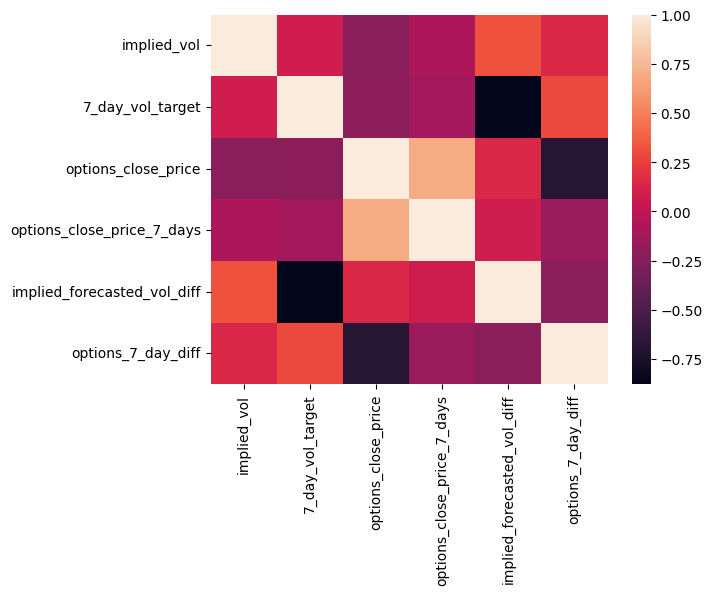

In [38]:
sns.heatmap(processed_df[["implied_vol","7_day_vol_target","options_close_price","options_close_price_7_days","implied_forecasted_vol_diff","options_7_day_diff"]].corr(method='spearman'))

In [ ]:
# Basic Model (Assuming we have the predicted futures realized_volatility)

